# Comparison of microscopic and macroscopic results in terms of the unified trajectory

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
micro_data = pd.read_pickle('../divestdata/P3/micro/unified_trajectory')
macro_data = pd.read_pickle('../divestdata/P3/aggregate/unified_trajectory')
print(macro_data.index.levels)
print(micro_data.index.levels)

[[1.0, 1.25, 1.5], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.1, 0.316227766017, 1.0, 3.16227766017, 10.0, 31.6227766017, 100.0, 316.227766017, 1000.0], [0.001, 0.005, 0.01, 0.05], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, ...], ['Pcd', 'Pdc', 'W_c', 'W_d', 'c', 'g', 'i_c', 'k_c', 'k_d', 'l_c', 'l_d', 'n_c', 'r', 'r_c', 'r_d', 'time', 'w']]
[[1.25], [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 

In [3]:
key = [1.25, 0.3, 1., 0.05]
level = ['b_d', 'phi', 'tau', 'eps']

tmax = 300

mean = micro_data.xs(level = level, key=key)['mean_trajectory'].unstack('observables')[0:tmax]
sem = micro_data.xs(level = level, key=key)['sem_trajectory'].unstack('observables')[0:tmax]

ma_mean = macro_data.xs(level = level, key=key)['mean_trajectory'].unstack('observables')[0:tmax]
ma_sem = macro_data.xs(level = level, key=key)['sem_trajectory'].unstack('observables')[0:tmax]


for i, df in enumerate([mean, sem, ma_mean, ma_sem]):
    
    columns = df.columns
    new_columns = pd.Index(['$'+col+'$' for col in columns.values], name=columns.name)
    df.columns = new_columns

def plot_var(name, mean, sem, ax, color, style, legend=True):
    
    t = mean.index.values
    m = mean[name].values
    s = sem[name].values
    
    if legend is False:
        name = '__no_label__'
    ln = ax.plot(t, m, style, color=color, label=name)
    ax.fill_between(t, m+s, m-s, alpha=.2, color=color)
    
    return ln

def legend_surrogates(styles, pos, ax):
    
    lns = []
    
    for name, style  in styles.items():
        ln = ax.plot(pos[0], pos[1], style, color='k', alpha=.5, label=name)
        lns += ln
        
    return lns

[<matplotlib.lines.Line2D object at 0x7f3c7ee8f2b0>, <matplotlib.lines.Line2D object at 0x7f3c7efac780>, <matplotlib.lines.Line2D object at 0x7f3c7efac710>, <matplotlib.lines.Line2D object at 0x7f3c7ee98550>]


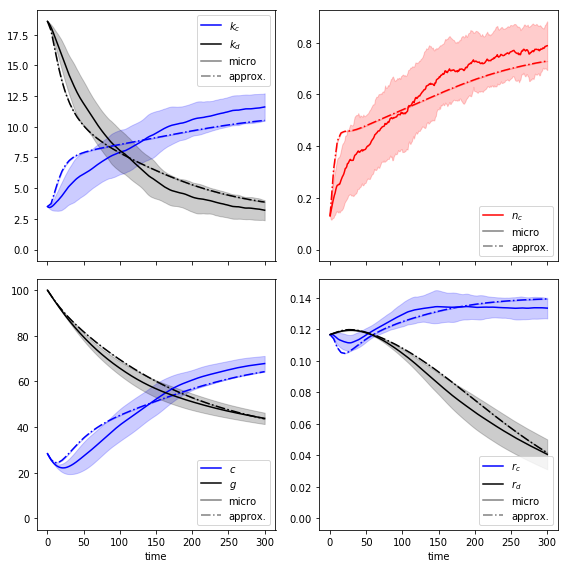

In [4]:
styles = {'micro': '-',
          'approx.': '-.'}

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221)
plot_var('$k_c$', mean, sem, ax1, 'b', '-')
plot_var('$k_d$', mean, sem, ax1, 'k', '-')

plot_var('$k_c$', ma_mean, ma_sem, ax1, 'b', '-.', legend=False)
plot_var('$k_d$', ma_mean, ma_sem, ax1, 'k', '-.', legend=False)

ax1.set_xticklabels([])
legend_surrogates(styles, [0, 0], ax1)
plt.legend()

ax2 = fig.add_subplot(222)
plot_var('$n_c$', mean, sem, ax2, 'r', '-')
plot_var('$n_c$', ma_mean, ma_sem, ax2, 'r', '-.', legend=False)

legend_surrogates(styles, [0, 0], ax2)
ax2.set_xticklabels([])
plt.legend(loc='lower right')

ax3 = fig.add_subplot(223)
#ax3b = ax3.twinx()
plot_var('$c$', ma_mean, ma_sem, ax3, 'b', '-.', legend=False)
plot_var('$g$', ma_mean, ma_sem, ax3, 'k', '-.', legend=False)

ln1 = plot_var('$c$', mean, sem, ax3, 'b', '-')
ln2 = plot_var('$g$', mean, sem, ax3, 'k', '-')

lns = legend_surrogates(styles, [0, 0], ax3)

lns = ln1 + ln2 + lns
print(lns)
labs = [ln.get_label() for ln in lns]

plt.legend(lns, labs, loc='lower right')

ax3.set_xlabel('time')

ax4 = fig.add_subplot(224)
plot_var('$r_c$', mean, sem, ax4, 'b', '-')
plot_var('$r_d$', mean, sem, ax4, 'k', '-')

plot_var('$r_c$', ma_mean, ma_sem, ax4, 'b', '-.', legend=False)
plot_var('$r_d$', ma_mean, ma_sem, ax4, 'k', '-.', legend=False)

legend_surrogates(styles, [0, 0], ax4)
plt.legend()
ax4.set_xlabel('time')

fig.tight_layout()
plt.savefig('micro_vs_approx.pdf')

In [5]:

import getpass
import itertools as it
import os
import pickle as cp
import sys
import time
from random import shuffle

import networkx as nx
import numpy as np
import pandas as pd
from pydivest.macro_model.integrate_equations_aggregate import Integrate_Equations as agg
from pydivest.macro_model.integrate_equations_mean import Integrate_Equations as mean
from pydivest.macro_model.integrate_equations_rep import Integrate_Equations as rep
from pydivest.micro_model.divestmentcore import DivestmentCore as micro
from pymofa.experiment_handling import experiment_handling, even_time_series_spacing

def RUN_FUNC(b_d, phi, tau, eps, model, test, filename):
    """
    Set up the model for various parameters and determine
    which parts of the output are saved where.
    Output is saved in pickled dictionaries including the 
    initial values, parameters and convergence state and time 
    for each run.

    Parameters:
    -----------
    b_d : float > 0
        the solow residual in the dirty sector
    phi : float \in [0,1]
        the rewiring probability for the network update
    tau : float > 0
        mean waiting time between household updates
    eps : float \in [0, 1]
        fraction of imitation and rewiring events that are random
    model: int
        if 0: run abm
        if 1: run mean approximation
        if 2: run aggregate approximation
        if 3: run representative agent approximation
    test: int \in [0,1]
        whether this is a test run, e.g.
        can be executed with lower runtime
    filename: string
        filename for the results of the run
    """

    # SET PARAMETERS:

    # investment_decisions:

    possible_cue_orders = [[0], [1]]

    # Parameters:

    input_parameters = {'i_tau': tau, 'eps': eps, 'b_d': b_d,
                        'b_c': 1., 'i_phi': phi, 'e': 10,
                        'G_0': 10000, 'b_r0': 0.1 ** 2 * 100,
                        'possible_cue_orders': possible_cue_orders,
                        'C': 100, 'xi': 1. / 8., 'd_c': 0.06, 's': 0.23,
                        'pi': 1./2., 'L': 100,
                        'campaign': False, 'learning': True,
                        'crs': True, 'test': test}

    # investment_decisions
    nopinions = [90, 10]
    opinions = []
    for i, n in enumerate(nopinions):
        opinions.append(np.full(n, i, dtype='I'))
    opinions = [item for sublist in opinions for item in sublist]
    shuffle(opinions)

    # network:
    N = sum(nopinions)
    p = .2

    while True:
        net = nx.erdos_renyi_graph(N, p)
        if len(list(net)) > 1:
            break
    adjacency_matrix = nx.adj_matrix(net).toarray()

    # use equilibrium value for only dirty investment here.
    Keq = (input_parameters['s'] * (1 - input_parameters['b_r0']
                                    / input_parameters['e']) / input_parameters['d_c']
           * input_parameters['b_d'] * input_parameters['L'] ** input_parameters['pi']) ** (1
                                                                                            / (input_parameters['pi']))

    # investment
    clean_investment = 3.5 * np.ones(N)
    dirty_investment = Keq / N * np.ones(N)

    init_conditions = (adjacency_matrix, opinions,
                       clean_investment, dirty_investment)

    models = {}

    m_rep = rep(*init_conditions, **input_parameters)
    C, n = m_rep.find_initial_conditions()

    input_parameters['C'] = C

    # investment_decisions
    nopinions = [int(round((1. - n) * 100.)), int(round(n * 100.))]
    if nopinions[1] < 1:
        nopinions[1] += 1
        nopinions[0] -= 1
    if nopinions[0] < 1:
        nopinions[0] += 1
        nopinions[1] -= 1
    opinions = []
    for i, n in enumerate(nopinions):
        try:
            opinions.append(np.full(n, i, dtype='I'))
        except ValueError:
            print(i, n)
            exit(-1)
    opinions = [item for sublist in opinions for item in sublist]
    shuffle(opinions)

    # network:
    N = sum(nopinions)
    p = .2

    while True:
        net = nx.erdos_renyi_graph(N, p)
        if len(list(net)) > 1:
            break
    adjacency_matrix = nx.adj_matrix(net).toarray()

    init_conditions = (adjacency_matrix, opinions,
                       clean_investment, dirty_investment)

    # initializing the model
    if model == 0:
        m = m_rep
    elif model == 1:
        m = micro(*init_conditions, **input_parameters)
    elif model == 2:
        m = mean(*init_conditions, **input_parameters)
    elif model == 3:
        m = agg(*init_conditions, **input_parameters)
    else:
        raise ValueError('model must be in [1, 2, 3] but is {}'.format(model))

    # storing initial conditions and parameters

    res = {
        "initials": pd.DataFrame({"Investment clean": m.investment_clean,
                                  "Investment dirty": m.investment_dirty}),
        "parameters": pd.Series({"i_tau": m.tau,
                                 "i_phi": m.phi,
                                 "N": m.n,
                                 "L": m.L,
                                 "savings rate": m.s,
                                 "clean capital depreciation rate": m.d_c,
                                 "dirty capital depreciation rate": m.d_d,
                                 "resource extraction efficiency": m.b_r0,
                                 "Solov residual clean": m.b_c,
                                 "Solov residual dirty": m.b_d,
                                 "pi": m.pi,
                                 "kappa_c": m.kappa_c,
                                 "kappa_d": m.kappa_d,
                                 "xi": m.xi,
                                 "resource efficiency": m.e,
                                 "epsilon": m.eps,
                                 "initial resource stock": m.G_0,
                                 "interaction": 2})}

    # run the model
    t_start = time.clock()

    t_max = 500
    exit_status = m.run(t_max=t_max, )

    res["runtime"] = time.clock() - t_start
    print(res['runtime'], tau)


    # store data in case of successful run

    if exit_status in [0, 1]:
        unified_trajectory = m.get_unified_trajectory()
        if isinstance(unified_trajectory, pd.DataFrame):
            res['unified_trajectory'] = even_time_series_spacing(
                unified_trajectory, t_max + 1, 0, t_max)
        else:
            print('run {} failed due to unified trajectory calculation. Should rerun.'.format(filename))
            return -1
    return res

assimulo not available. Running model impossible.


In [6]:
args = {key: val for key, val in zip(level, key)}
args['model'] = 3
args['test'] = 1
args['filename'] = 'dummy'

res = RUN_FUNC(**args)

got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
sanitizing initial conditions to
{K_c: 350.0, K_d: 1859.7656250000002, G: 10000.0, C: 2838.201141357421, n: 0.13496425736387072}
got superfluous keyword arguments
dict_keys(['possible_cue_orders', 'campaign', 'learning'])
pi = 0.5, xi = 0.125, kappa_c = 0.375, kappa_d = 0.5
define economic equations,
loading rhs successful
lambdify rhs
integrating equations from t=0 to t=500
2.538246000000001 1.0========================================] 100.3% ...aggregate approximation running


/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/jakob/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


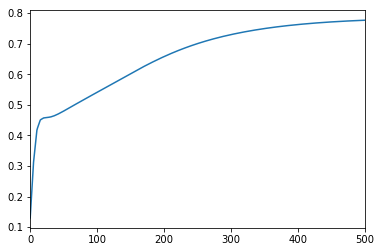

In [7]:
res['unified_trajectory']['n_c'].plot()